In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from scipy import ndimage

In [3]:
import nibabel as nib

## Training data

In [4]:

data_path = 'TFM_data/Training_t1ce/'# Carpeta donde están los 162 archivos _t1ce.nii.gz
seg_path = 'TFM_data/Training_seg/' # Carpeta con los 162 archivos _seg.nii.gz

imgs_names = []
    
for base, dirs, files in os.walk(data_path):
    imgs_names = files


In [5]:
imgs_names.sort()
# imgs_names

In [6]:
imgs_names[3][:-11] # toma hasta los ultimos 11 elementos que es donde aparece el tipo de archivo

'Brats18_2013_13_1_'

In [7]:
# modificamos el nombre para que tengan la ruta para poder cargarlos con nib.load 
tags_names = imgs_names.copy()

for i in range(len(imgs_names)):
    imgs_names[i] = data_path + imgs_names[i]
    tags_names[i] = seg_path + tags_names[i][:-11] + 'seg.nii.gz'


In [8]:
# creamos las listas vacías donde se almacenarán las imágenes
data = []
imagenes = []

for i in range(len(imgs_names)):
    data.append(nib.load(imgs_names[i]))
    imagenes.append(data[i].get_data())
    

In [9]:
# hacemos lo mismo pero para las etiquetas
data_seg = []
etiquetas = []

for i in range(len(tags_names)):
    data_seg.append(nib.load(tags_names[i]))
    etiquetas.append(data_seg[i].get_data())

### Explorando los datos

In [10]:
len(imagenes) # número de pacientes

162

In [11]:
imagenes[1].shape # dimensión de datos por paciente (cada cerebro dividido en 240 rebanadas)

(240, 240, 155)

In [12]:
print("Dimension de una imagen axial de RM: ",imagenes[1][:,:,4].shape)

Dimension de una imagen axial de RM:  (240, 240)


## Eliminamos la agrupación de imágenes y etiquetas por paciente

El siguiente paso se realiza en tres pasos por separado, ya que al hacerlo en un solo paso tardaba mucho en ejecutar.
Los tres arrays resultantes se concatenarán al final en uno solo.

In [22]:
imagenes = np.asarray(imagenes)
imagenes2 = imagenes.copy()

In [23]:
# invertimos el orden de los ejes para poder eliminar la agrupación por pacientes
imagenes2 = np.transpose(imagenes2, (0,3,2,1)) 

In [24]:
imagenes2.shape

(162, 155, 240, 240)

In [25]:
# agrupamos los dos primeros índices
x = np.reshape(a=imagenes2, newshape=(25110,240,240))

In [26]:
x.shape

(25110, 240, 240)

In [28]:
# Guardamos este array de imagenes
np.save('x.npy', x)

In [30]:
# ETIQUETAS
etiquetas = np.asarray(etiquetas)
etiquetas2 = etiquetas.copy()

In [31]:
etiquetas2 = np.transpose(etiquetas2, (0,3,2,1))
y = np.reshape(a=etiquetas2, newshape=(25110,240,240))

In [32]:
y.shape

(25110, 240, 240)

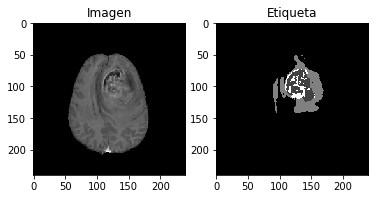

In [40]:
plt.subplot(1,2, 1)
plt.imshow(x[25050], cmap='gray')
plt.title('Imagen')

plt.subplot(1,2, 2)
plt.imshow(y[25050], cmap='gray')
plt.title('Etiqueta')

plt.show()

In [23]:
# Guardamos este array de etiquetas
np.save('y.npy', y)

---

##  Cargar los datos (solo si se empieza desde este punto)

In [4]:
# x = np.load('x.npy')
# y = np.load('y.npy')

In [41]:
# Copia de los datos, por si hubiera que volver a usarlos.
prueba = x.copy() 
pruebaetiq = y.copy() 

----------------------

## Reducir el dataset

Dado que si entrenamos la red con la totalidad de las imágenes se demoraría mucho, los dos procedimientos seguidos para acortar el dataset son los siguientes:

- **Eliminar imágenes del dataset de TCIA.** Esto se debe a que la calidad de las imágenes es bastante baja en comparación con la de otras imágenes de los otros datsets. Este conjunto de datos lo componen los últimos 54 pacientes, por lo que habrá un total de 12960 imágenes procedentes de este dataset.

- **Eliminar las imágenes del principio y final del escáner de RM del paciente.** Estas primeras y últimas imágenes serán completamente negras, por lo que no aportarán ningún tipo de información a nuestro entrenamiento, y lo único que harían sería demorarlo.

In [42]:
# Nos quedamos con todas las imágenes, menos las 12960 últimas. 
# Es decir, tomamos las 25920 primeras imágenes de nuestro conjunto

prueba = prueba[0:25920]
pruebaetiq = pruebaetiq[0:25920]

## Normalización imágenes

Crearemos una función que normalice las imágenes. Para ello, buscará el valor máximo de cada imagen, y la dividirá toda ella por este valor. De este modo, el mapa de píxeles que compondrá la imagen tendrá un rango de 0 a 1.

Asímismo, esta función no hará ninguna acción sobre las imágenes que sean totalmente negras, es decir, las que se componen exclusivamente por 0s. Estas las dejará intactas, puesto que si las dividiera por su máximo (en este caso, 0), serían matrices compuestas por nan. De este modo, las imágenes seguirán siendo mapas de 0s.

In [43]:
def normalizar(imagenes):
    """Normaliza las imágenes contenidas en el array que se pasa como parámetro,
    dividiéndo el valor de todos sus píxeles por el máximo.
    No hace nada si la imagen es totalmente negra, i.e. suma = 0.
    De este modo el mapa de píxeles tendrá valores entre 0 y 1"""
    imgs = imagenes.copy()
    
    imgs_norm = [imgs[i]/np.max(imgs[i]) if np.sum(imgs[i])!=0 else imgs[i] for i in range(len(imgs)) ]  
    imgs_norm = np.asarray(imgs_norm)
        
    return imgs_norm

In [44]:
# Normalizamos ahora las imágenes
prueba2 = normalizar(prueba)

In [46]:
# Comprobamos que efectivamente se han normalizado las imágenes, 
# tomando un elemento cualquiera de nuestro array inicial, y el mismo
# del nuevo array, para ver si los píxeles tienen valores entre 0 y 1

print('Antes de normalizar:')
print(prueba[65][120])
print('')
print('Después de normalizar:')
print(prueba2[65][120])

# Comprobamos también que las imágenes inciales, compuestas solo por 0s, siguen igual y no aparecen como nan
print('')
print('Imagen negra después de normalizar:')
print(prueba2[1][120])

Antes de normalizar:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0   75
   96  307  600  569  526  561  549  616  650  674  881  946  664  488
  759 1203 1385 1210  942  813  681  450  343  388  425  422  420  440
  473  483  494  514  502  489  489  483  485  502  550  607  600  639
  937 1269 1201  817  565  550  544  498  482  490  490  468  452  451
  447  474  554  615  612  588  586  589  580  560  509  478  490  387
  261  326  446  466  483  532  565  588  599  606  614  603  589  578
  560  561  575  561  539  539  519  532  587  507  356  390  532  576
  558  572  554  512  476  427  457  489  372  342  455  445  387  437
  518  583  614  580  558  583  587  569  544  525  515  489  493  484
  115    0    0    0    0    0    0    0    0    0    0 

## Eliminar imágenes negras

Las primeras y últimas imágenes de cada escáner de RM son totalmente negras, por lo que no aportan ninguna información útil a nuestra red. Es por esto que las eliminaremos para reducir las dimensiones de nuestro dataset y que el entrenamiento de la red neuronal no se demore demasiado.

También es conveniente eliminar aquellas imágenes que son prácticamente negras en su totalidad y tampoco aportan mucha info para el entrenamiento. Estas imágenes tienen píxeles distintos de 0, pero estableceremos un umbral (suma de los píxeles de la imagen) mínimo a partir del cual consideraremos que la imagen aporta información relevante a nuestra red.


In [47]:
def eliminar_no_relevantes(imagenes, etiquetas, umbral): 
    """Del array de imágenes de rebanadas de cerebro que se pasa, guarda el índice de aquellas 
    cuya suma sea inferior a un umbral, ya que serán imágenes casi completamente negras que no aporten mucha información. 
    Se obtienen los índices de las imágenes que nos interesan y se hace slicing del array original con estos índices.
    Hace lo mismo con las etiquetas correspondientes."""
    
    # posiciones de las imágenes casi enteras negras
    indices_negras = [i for i,img in enumerate(imagenes) if np.sum(imagenes[i]) < umbral]
    indices_negras = np.asarray(indices_negras) # convertimos la lista a array
    
    indices_todas = np.arange(len(imagenes))
    
    # posiciones de las imágenes con las que nos queremos quedar
    ind_buenas = np.setdiff1d(indices_todas, indices_negras)
    
    imagenes2 = imagenes[ind_buenas]
    etiquetas2 = etiquetas[ind_buenas]
    
    return imagenes2, etiquetas2

Vamos a mostrar algunas imágenes con sus etiquetas correspondientes. Además, buscaremos una imagen que consideremos que no aporta la suficiente información relevante para nuestra red y obtendremos la suma de sus píxeles. 

Este valor nos servirá como umbral de referencia para eliminar otras imágenes poco relevantes.

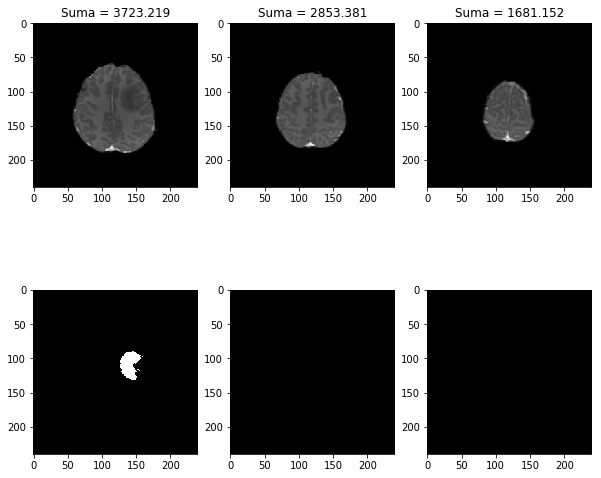

In [59]:
fig = plt.figure(figsize = (10, 9))


plt.subplot(2,3, 1)
plt.imshow(prueba2[265],cmap='gray')
plt.title('Suma = {}'.format(round(np.sum(prueba2[265]),3)))

plt.subplot(2,3, 2)
plt.imshow(prueba2[275],cmap='gray')
plt.title('Suma = {}'.format(round(np.sum(prueba2[275]),3)))

plt.subplot(2,3, 3)
plt.imshow(prueba2[285],cmap='gray')
plt.title('Suma = {}'.format(round(np.sum(prueba2[285]),3)))


plt.subplot(2,3, 4)
plt.imshow(pruebaetiq[265],cmap='gray')

plt.subplot(2,3, 5)
plt.imshow(pruebaetiq[275],cmap='gray')

plt.subplot(2,3, 6)
plt.imshow(pruebaetiq[285],cmap='gray')

plt.show()

Vemos que la imagen de la derecha, correspondiente a la rebanada 316, ya empieza a mostrar la estructura casi completa del cerebro, por lo que eliminar imágenes similares a esta sería perder información.

Sin embargo, la imagen central (y menos aún la de la izquierda), todavía no muestran la suficiente información relevante para nuestra red neuronal. Por tanto, obtendremos la suma de los píxeles de la imagen 306 para establecer el umbral. 
**Este paso es muy importante realizarlo después de haber normalizado las imágenes, para que el umbral sirva por igual a todas.**

In [60]:
print('Suma de los píxeles de la rebanada 275: ',np.sum(prueba2[275]))

Suma de los píxeles de la rebanada 275:  2853.380710659899


Observando este valor, tomaremos 2500 como umbral de referencia para eliminar aquellas imágenes cuya suma del valor de sus píxeles no supere esta cantidad.

In [61]:
print('Antes de eliminar las imágenes poco relevantes, nuestro dataset tenía:')
print(len(prueba2), 'imágenes')
print(len(pruebaetiq), 'etiquetas')

Antes de eliminar las imágenes poco relevantes, nuestro dataset tenía:
25110 imágenes
25110 etiquetas


In [62]:
imgs,tags = eliminar_no_relevantes(imagenes=prueba2, etiquetas=pruebaetiq, umbral=2500)

In [63]:
print('Después de eliminar las imágenes poco relevantes, nuestro dataset tiene:')
print(len(imgs), 'imágenes')
print(len(tags), 'etiquetas')

Después de eliminar las imágenes poco relevantes, nuestro dataset tiene:
14379 imágenes
14379 etiquetas


Como se puede ver, el dataset se ha reducido más la mitad, lo que indica que una gran cantidad de las imágenes estaban "haciendo bulto" en nuestro dataset. Ahora, con un conjunto de datos más reducido, el entrenamiento de la red será mucho más rápido.

##  Binarizar etiquetas

Las etiquetas proporcionada por la organización de BraTS 2018 muestran la segmentación del glioma en el cerebro, diferenciando varias partes.

Para hacerlo más sencillo, se ha decidido convertir estas etiquetas en binarias, de modo que las imágenes segmentadas sean mapas de 0s y 1s. De este modo, simplemente se identificaría la posición del tumor, sin hacer ninguna distinción de sus partes


In [64]:
# FUNCIÓN PARA HACER ETIQUETAS BINARIAS
# En agradecimientos, incluir a Stack overflow, por salvarnos la vida con las dudas de código

def binarizar_etiqueta(etiquetas):
    """Función a la que se le pasa un array de imágenes segmentadas. 
    Hace una copia para que no modificar el array original.
    Convierte el mapa de píxeles en binario, haciendo 1 cualquier píxel con valor distinto de 0."""
    
    tags = etiquetas.copy()
    for tag in tags:
        tag[tag > 0] = 1
    
    return tags

In [65]:
tags_bin = binarizar_etiqueta(tags)

In [73]:
print('Antes de binarizar:')
print(tags[20][120])
print('')
print('Después de binarizar:')
print(tags_bin[20][120])

Antes de binarizar:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 4 4 4 4 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Después de binarizar:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 

Observamos que las etiquetas se han hecho binarias. Vamos a mostrar un ejemplo de imagen de cerebro con sus etiquetas correspondientes, la original y la binaria.

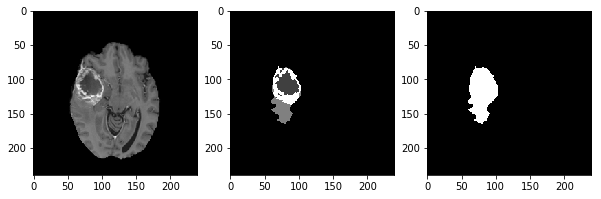

In [77]:
fig = plt.figure(figsize = (10, 9))


plt.subplot(1,3, 1)
plt.imshow(imgs[30],cmap='gray')

plt.subplot(1,3, 2)
plt.imshow(tags[30],cmap='gray')

plt.subplot(1,3, 3)
plt.imshow(tags_bin[30],cmap='gray')

Vamos a guardar los arrays obtenidos, de modo que se puedan cargar en futuras ocasiones sin tener que ejecutar todo el código de nuevo.

In [78]:
np.save('imgs.npy', imgs)
np.save('tags.npy', tags)
np.save('tags_bin.npy', tags_bin)

------

## Carga de imágenes y etiquetas binarias (solo si se empieza en este punto)

In [ ]:
# imgs = np.load('imgs_preproc.npy')
# tags_bin = np.load('etiq_bin.npy')

---

## Separación en train y test

Para entrenar nuestra red, haremos una partición de train/test del 75/25 %.
Tomaremos imágenes aleatoriamente del dataset global, junto con su etiqueta correspondiente.

In [79]:
import random

n = list(range(len(imgs)))
# selección aleatoria del 75% de los elementos contenidos en n
ind_train = random.sample(n, round(0.75*len(n))) 
# elementos ordenados
ind_train.sort()
# mete en una lista los índices que no están en ind_train
ind_test = [item for item in n if item not in ind_train] 

In [80]:
print(len(ind_train), 'elementos de train')
print(len(ind_test), 'elementos de test')

10784 elementos de train
3595 elementos de test


In [81]:
imgs_train = imgs[ind_train]
imgs_test = imgs[ind_test]

tags_train = tags_bin[ind_train]
tags_test = tags_bin[ind_test]

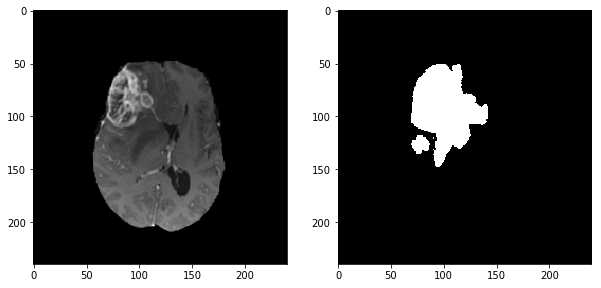

In [85]:
fig = plt.figure(figsize = (10, 9))

plt.subplot(1,2, 1)
plt.imshow(imgs_train[165],cmap='gray')

plt.subplot(1,2, 2)
plt.imshow(tags_train[165],cmap='gray')

In [86]:
np.save('x_train', imgs_train)
np.save('x_test', imgs_test)

In [87]:
np.save('y_train', tags_train)
np.save('y_test', tags_test)